In [1]:
import urllib.request
import gzip
import shutil
import os

import time
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation

In this notebook we go through the process of training a recurrent neural network (RNN) to learn to approximate the codon use distribution of *Bacillus subtilis*.

First, we download the *B. subtilis genome*. Much of this first bit is repeated from the HMM example in `1_bsubtilis_codons_hmms.ipynb`.

In [2]:
url = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/009/045/GCF_000009045.1_ASM904v1/GCF_000009045.1_ASM904v1_genomic.gbff.gz'
gz_fn = 'GCF_000009045.1_ASM904v1_genomic.gbff.gz'
gbk_fn = gz_fn.replace('.gbff.gz', '.gbk')
if not os.path.isfile(gz_fn):
    print('Beginning file download with urllib2...')
    urllib.request.urlretrieve(url, gz_fn)

if not os.path.isfile(gbk_fn):
    with gzip.open(gz_fn, 'rb') as f_in, open(gbk_fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

Some helper functions to split a nucleotide sequence into codons and check for ambiguous codons or sequences with lengths that aren't a multiple of 3.

As always, `assert` statements are little tests to make sure that things are working the way we expect. They are *very* helpful for catching silly bugs.

In [3]:
def get_list_of_codons(dna_seq):
    codons = []
    for i in range(0, len(dna_seq), 3):
        codons.append(dna_seq[i:i+3])
    return codons
assert get_list_of_codons('ATGCCCGGGAAATTTTAG') == ['ATG', 'CCC', 'GGG', 'AAA', 'TTT', 'TAG']

def check_len_and_ambiguity(seq):
    assert isinstance(seq, str)
    ambig_nucs = ['R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N']
    unambiguous = not any([anuc in seq for anuc in ambig_nucs])
    multiple_3 = len(seq) % 3 == 0
    return unambiguous and multiple_3
assert check_len_and_ambiguity('ATGACCTAG')
assert not check_len_and_ambiguity('ATGACCTA')
assert not check_len_and_ambiguity('ATGACCTAY')
assert not check_len_and_ambiguity('ATGACCAY')

And now we read in all the protein coding sequences from the genome. During this process, we keep track of the set of unique amino acids and nucleotides, the initial states, and---of great importance---the codons that correspond to each amino acid.

In [4]:
STOP_SYMB = '&'
u_aas = set([STOP_SYMB])
u_codons = set([STOP_SYMB])
translations = {}
for record in SeqIO.parse(gbk_fn, "genbank"):
    for feature in record.features:
        if feature.type == 'CDS' and \
           'translation' in feature.qualifiers:
            if check_len_and_ambiguity(str(record.seq)):
                protein = feature.qualifiers['translation'][0] + '*'
                aas = {aa for aa in protein}
                nucleotide_seq = str(feature.extract(record.seq))
                codon = get_list_of_codons(nucleotide_seq)
                if len(protein) == len(codon):
                    u_aas = u_aas.union(aas)
                    u_codons = u_codons.union(set(codon))
                    translations[protein] = nucleotide_seq
#         if len(translations) >= 300:
#             break
lu_aas = list(u_aas)
lu_codons = list(u_codons)

Familiar helper functions to encode and decode sequences.

In [5]:
def encode_seq(seq_obj, seqtype='dna'):
    encdr = lu_codons
    symbols = get_list_of_codons(seq_obj)
    if seqtype != 'dna':
        encdr = lu_aas
        symbols = [c for c in seq_obj]
    outseq = np.array([encdr.index(s) for s in symbols])
    return outseq

test_aa = 'MENILD'
test_nuc = 'AAAAAAATAAGATAG'
assert encode_seq(test_aa, seqtype='prot')[0] == lu_aas.index(test_aa[0]) and \
       encode_seq(test_aa, seqtype='prot')[-1] == lu_aas.index(test_aa[-1])
assert encode_seq(test_nuc, seqtype='dna')[0] == lu_codons.index(test_nuc[0:3]) and \
       encode_seq(test_nuc, seqtype='dna')[-1] == lu_codons.index(test_nuc[-3:])

def decode_seq(num_array, seqtype='dna'):
    encdr = lu_codons
    if seqtype != 'dna':
        encdr = lu_aas
    outseq = [encdr[s] for s in num_array]
    return ''.join(outseq)

assert decode_seq(encode_seq(test_nuc)) == test_nuc
assert decode_seq(encode_seq(test_aa, seqtype='prot'), seqtype='prot') == test_aa

Our data set will consist of PyTorch tensors. These are simply numerical matrices (like you would find in Numpy or MATLAB or R), but they include the ability to track gradients.

This case is more complex than the toy example because all the sequences of different lengths. For now we will deal with this by padding the empty space at the end of a sequence with a stop symbol "&".

In [6]:
SEQ_LEN = np.max([len(key) for key in translations.keys()])
NUM_SEQS = len(translations)
BATCH_SIZE = 1
ENC_STOP_DNA = encode_seq(STOP_SYMB, seqtype='dna')[0]
ENC_STOP_PROT = encode_seq(STOP_SYMB, seqtype='prot')[0]
TEST_FRACTION = 0.2
np.random.seed(2021)

# Split protein/DNA pairs into random training and test set
test_indices = choice(NUM_SEQS, 
                      size=int(np.floor(TEST_FRACTION*NUM_SEQS)), 
                      replace=False)
train_indices = [x for x in range(NUM_SEQS) if x not in test_indices]
trnslts_lst = list(translations.items())
test_translations = dict([trnslts_lst[x] for x in test_indices])
train_translations = dict([trnslts_lst[x] for x in train_indices])

# Convert dictionary of protein/DNA pairs into tensors
def seq_dict_to_tensors(seq_dict, 
                        seq_len, 
                        enc_stop_dna, 
                        enc_stop_prot):
    assert len(seq_dict) > 0
    
    X = torch.ones(len(seq_dict), 
                   seq_len, 
                   dtype=torch.long)*enc_stop_prot
    Y = torch.ones(len(seq_dict), 
                   seq_len, 
                   dtype=torch.long)*enc_stop_dna
    for i, prot in enumerate(seq_dict):
        codons = seq_dict[prot]
        prot_encode = torch.LongTensor(encode_seq(prot, seqtype='prot'))
        codn_encode = torch.LongTensor(encode_seq(codons, seqtype='dna'))

        X[i, :len(prot_encode)] = prot_encode
        Y[i, :len(prot_encode)] = codn_encode
    return X, Y

X_test, Y_test = seq_dict_to_tensors(test_translations,
                                     SEQ_LEN,
                                     ENC_STOP_DNA,
                                     ENC_STOP_PROT)
X_train, Y_train = seq_dict_to_tensors(train_translations,
                                     SEQ_LEN,
                                     ENC_STOP_DNA,
                                     ENC_STOP_PROT)

In [7]:
X_train.shape, Y_train.shape

(torch.Size([3389, 5489]), torch.Size([3389, 5489]))

In [8]:
X_test.shape, Y_test.shape

(torch.Size([847, 5489]), torch.Size([847, 5489]))

Next, we load the data into a `Dataset` and `Dataloader` module. This is not strictly necessary for training, but it makes it easier to shuffle, sample from and batch the data. When projects get more complicated, these modules are very helpful.

In [9]:
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_data = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

Here we make sure the data comes back out of the dataloader in the way we expect. The `batch_size` refers to the number of examples sampled simultaneously. In this case, we only retrieve one example sequence at a time. 

In [10]:
# Make sure the data comes back out in the way we expect
train_features, train_labels = next(iter(train_loader))
train_features.shape, train_labels.shape

(torch.Size([1, 5489]), torch.Size([1, 5489]))

Here we set up a [python class](https://www.geeksforgeeks.org/python-classes-and-objects/) to manage the various pieces of our model. Again, this is not strictly necessary, but it makes life simpler. For example, the class will track useful information internally (e.g. `input_size`, `n_layers`). We can also create convenience functions such as `init_hidden()` to create a fresh hidden layer without having to remember what the precise dimensions ought to be. 

There are two pieces to our class. The `__init__()` function that is run when we first instantiate an instance of `MyGruClass`. This is where we initialize variables with the correct values, and instantiate the machine learning layers. A Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN). Notice the Tensorflow GRU module is called here (which is the heart of our model). We also include an ["embedding" layer](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526), which learns to represent our integer inputs (remember we converted our sequence of characters into a sequence of integers using the `encode_seq()` function) as a vector of foating point numbers. That vector of floating point numbers serves as the input to our GRU. Finally, we instantiate a `Linear` and `LogSoftMax` layer, both of which convert the GRU output into a sequence of log probabilities. 

The `forward()` function is where we actually *use* the layers we created with `__init()`. In `forward()` we take an input and cascade it through the layers to produce an output. The key to any kind of deep learning project is to carefully track the input and output dimensions of your layers. Notice my comments to help myself mentally track what each layer is spitting out, and what the next layer expects. It helps to be aware of the [`transpose()` function](https://pytorch.org/docs/stable/generated/torch.transpose.html), which allows you to rotate two dimensions. This helps to match a tensor with the input expections of a layer. 

In [11]:
class MyGruClass(nn.Module):
    def __init__(self, input_size, hidden_size, predict_size, n_layers=1, bdir=False):
        super(MyGruClass, self).__init__()
        self.input_size = input_size
        self.embed_size = input_size
        self.hidden_size = hidden_size
        self.predict_size = predict_size
        self.n_layers = n_layers
        self.n_directions = 2 if bdir else 1
        
        self.embedding = nn.Embedding(input_size, self.embed_size)
        self.gru = nn.GRU(self.embed_size, 
                          hidden_size, 
                          num_layers=n_layers, 
                          bidirectional=bdir)

        self.lin_out = nn.Linear(hidden_size*self.n_directions, predict_size)
        self.sigmoid = nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        # embedding shape: (batch_size, seq_len, hidden_size)
        # transpose so that batch dim is in the 2nd index position
        output = torch.transpose(embedded, 0, 1)
        
        output, hidden = self.gru(output, hidden)
        # output shape: (seq_len, batch_size, n_directions*hidden_size)
        # hidden shape: (n_directions*n_layers, batch_size, hidden_size)
        
        output = self.sigmoid(self.lin_out(output))
        return output, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(self.n_layers*self.n_directions, 
                           batch_size, 
                           self.hidden_size)

    def input_dims(self):
        print(f'Input dimensions are: (batch_size, seq_len, {self.input_size})')
    
    def output_dims(self):
        print(f'Output dimensions are: (seq_len, batch_size, {self.predict_size})')
    
    def hidden_dims(self):
        dnl = self.n_layers*self.n_directions
        print(f'Hidden dimensions are: ({dnl}, batch_size, {self.hidden_size})')

In [12]:
# Using convenience functions in MyGruClass to print expected dimensions
test_model = MyGruClass(len(lu_aas), 10, len(lu_codons))
test_model.input_dims(), test_model.hidden_dims(), test_model.output_dims();

Input dimensions are: (batch_size, seq_len, 22)
Hidden dimensions are: (1, batch_size, 10)
Output dimensions are: (seq_len, batch_size, 65)


The `train()` function is where the action happens. Here we instantiate our model, and start feeding data to it. We select the Negative Log-Likelihood Loss `NLLLoss()` [function](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) as our optimization function because it determines whether a log probality (the output of our GRU) correctly classifies the input. In other words, the more probability the model assigns to the correct category, the more the the model is "rewarded". 

In our case, the model will output a vector of 65 probabilities (log transformed), one each possible codon (plus the buffer symbol "&"). For every input amino acid, the model will assign the probability that it corresponds to each codon. The training data also has the true codons from the genom to which the model can compare its prediction. The more probability assigned to the correct codon, the more the current model weights are reinforced.

There are many loss functions, all intended for different scenarios or that have different emphases. When starting a new project, it's worth reviewing the [available loss functions](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7) to pick the one or two that seem most appropriate.

PyTorch also offers [multiple optimization algorithms](https://pytorch.org/docs/stable/optim.html). For this project we went with a common default: Adam. 

Having initialized training data, a model, a loss function, and an optimizer, we are ready to learn. The training process proceeds to loop through the data set in a random order (because we set the `shuffle` parameter on our Dataloader to `True`). A full loop through the data is called an "epoch". Within each epoch, we iterate through every training batch (in this case, batches are just one sequence long). Before feeding a sequence to our RNN, we reset the hidden state and the gradient. We then feed the training sequence to our model, and collect the prediction output. The output is then reorganized (using `transpose()`) to match the input expections of our NLLLoss function. Once we get a loss value, we call `backward()` to calculate derivatives, and which are fed to the optimization function, which updates the model weights. It's remarkable how much PyTorch keeps track of for us.

Finally, there are some print statements to keep track of where we are in the loop, and whether the model is continuing to improve or not.

In [13]:
def rm_buffer(x, y, stop_symbol):
    buf_seq_locs = np.where(x.numpy() == ENC_STOP_PROT)
    if buf_seq_locs[0].shape[0] > 0:
        end_of_seq = buf_seq_locs[1][0]
        x = x[:, :end_of_seq]
        y = y[:, :end_of_seq]
    return x, y

def get_test_loss(model, loader, batch_size):
    '''Calculate cumulative loss over test data set.'''
    
    print("   Testing...")
    criterion = nn.NLLLoss()
    model.eval()
    avg_loss = 0
    for sample_x, sample_y in loader:
        h = model.init_hidden(batch_size)
        model.zero_grad()

        # Remove buffer symbols
        sample_x, sample_y = rm_buffer(sample_x, sample_y, ENC_STOP_PROT)

        # the heart of the training!
        out, h = model(sample_x, h)

        # NLLLoss expects batch first, then class probabilities, then seq_len
        out_T = torch.transpose(out, 0, 1)
        out_T = out_T.transpose(1, 2)

        loss = criterion(out_T, sample_y)
        avg_loss += loss.item()
    return avg_loss

def train(loader_training,
          loader_testing,
          learn_rate=0.02, 
          input_dim=len(lu_aas), 
          hidden_dim=10,
          output_dim=len(lu_codons),
          batch_size=1,
          EPOCHS=5):
    
    # Instantiating the model
    model = MyGruClass(input_dim, hidden_dim, output_dim)
    
    # Defining loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    print("Starting training")
    epoch_losses = {'epoch':[], 'train_loss':[], 'test_loss':[]}
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS+1):
        test_loss = get_test_loss(model, loader_testing, batch_size)
        train_loss = 0
        model.train()
        start_time = time.time()
        
        for sample_x, sample_y in loader_training:
            h = model.init_hidden(batch_size)
            model.zero_grad()
            
            # Remove buffer symbols
            sample_x, sample_y = rm_buffer(sample_x, 
                                           sample_y, 
                                           ENC_STOP_PROT)
            # the heart of the training!
            out, h = model(sample_x, h)
            
            # NLLLoss expects batch first, then class probabilities,
            # then seq_len
            out_T = torch.transpose(out, 0, 1)
            out_T = out_T.transpose(1, 2)
            
            # Calculate loss function, back propagate
            loss = criterion(out_T, sample_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Calculate average loss / sample and store results
        ave_train_loss = train_loss/len(loader_training)
        ave_test_loss = test_loss/len(loader_testing)
        current_time = time.time()
        epoch_losses['epoch'].append(epoch)
        epoch_losses['train_loss'].append(ave_train_loss)
        epoch_losses['test_loss'].append(ave_test_loss)
        
        print(f'Epoch {epoch}/{EPOCHS} Done')
        print(f'  Training Loss: {ave_train_loss:.3f}')
        print(f'  Testing Loss: {ave_test_loss:.3f}')
        print(f"  Total Time Elapsed: {current_time-start_time:.1f} seconds")
        epoch_times.append(current_time-start_time)
    print(f"Total Training Time: {sum(epoch_times):.1f} seconds")
    
    return model, pd.DataFrame(epoch_losses)

And now, for the big moment. We train the model! 

This will take a about 30 seconds to run.

In [14]:
gru_model, loss_history = train(train_loader, 
                                test_loader, 
                                learn_rate = 0.02, 
                                EPOCHS=3)

Starting training
   Testing...
Epoch 1/3 Done
  Training Loss: 1.117
  Testing Loss: 4.202
  Total Time Elapsed: 190.1 seconds
   Testing...
Epoch 2/3 Done
  Training Loss: 1.091
  Testing Loss: 1.086
  Total Time Elapsed: 190.0 seconds
   Testing...
Epoch 3/3 Done
  Training Loss: 1.089
  Testing Loss: 1.083
  Total Time Elapsed: 190.0 seconds
Total Training Time: 570.1 seconds


Training proceeded nicely. We can visualize the loss function value for the training and test sets over time to get a sense of when additional training is no longer useful.

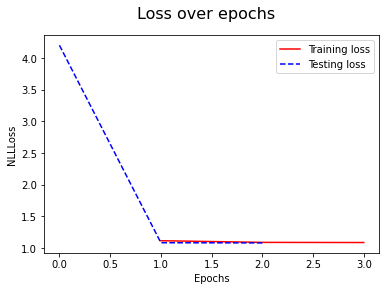

In [15]:
plt.plot(loss_history['epoch'], 
         loss_history['train_loss'], 'r', 
         loss_history['test_loss'], 'b--')
plt.legend(['Training loss', 'Testing loss'])
plt.xlabel('Epochs')
plt.ylabel('NLLLoss')
plt.suptitle('Loss over epochs', fontsize=16);

It looks like very little progress is made after 3 epochs.

Let's see how the GRU's predictions compare to a real example!

First, we need a function to handle all the steps of encoding and decoding the output and resetting the model. This function outputs both the predicted state (a string of H's and L's), and the associated probabilities.

In [16]:
def predict(model, protein):
    assert all([x in u_aas for x in protein])
    assert isinstance(model, MyGruClass)
    prot_encode = torch.LongTensor(encode_seq(protein, seqtype='prot'))
    prot_encode = prot_encode[None, :]
    h = model.init_hidden(1)
    model.zero_grad()
    out, _ = model(prot_encode, h)
    out_state_indices = [int(torch.argmax(x)) for x in out[:,0]]
    out_probs = np.array([torch.exp(x).detach().numpy() for x in out[:,0]])
    codons = decode_seq(out_state_indices, 'dna')
    return codons, out_probs

test_aa = 'MENILD'
test_nucleotides, test_probs = predict(gru_model, test_aa)
assert len(test_nucleotides) == len(test_aa)*3
test_codons = get_list_of_codons(test_nucleotides)
assert all([x in u_codons for x in test_codons])

Here we pick a sequence from our testing data that the model has never seen. We can align the prediction and the HMM generated sequence to see how closely they agree.

In [17]:
test_protein = list(test_translations.keys())[0]
test_dna = test_translations[test_protein]
pred_dna, pred_prob_dna = predict(gru_model, test_protein)

def align(seq1, seq2, WIDTH=60):
    '''Align two input sequences of equal length,
    with *  between indicating mismatches.'''
    lines = int(np.ceil(len(seq1) / WIDTH))
    match = ''
    for i, c1 in enumerate(seq1):
        indicator = ' '
        if c1 != seq2[i]:
            indicator = '*'
        match += indicator
    
    for i in range(lines):
        print('Seq1', seq1[i*WIDTH:i*WIDTH+WIDTH])
        print('    ', match[i*WIDTH:i*WIDTH+WIDTH])
        print('Seq2', seq2[i*WIDTH:i*WIDTH+WIDTH])
        print()

align(test_dna, pred_dna)

Seq1 ATGCACGTGTCAACATTTCAAGCATTAATGCTTATGCTTGCTTTCGGGTCATTTATAATT
     *    *     *           ** *              *  *  *  *     *   
Seq2 GTGCATGTGTCTACATTTCAAGCGCTTATGCTTATGCTTGCGTTTGGCTCTTTTATTATT

Seq1 GCCCTGTTGACTTATATAAAGAAGAAATAG
       *  ** *  *     *  *  *     *
Seq2 GCGCTTCTTACATATATTAAAAAAAAATAA



In [18]:
def build_codon_usage_table(prot_dna_dict):
    '''Returns a codon usage table.'''
    cu_dict = {'amino_acid':[],
               'codon':[]}
    for prot in prot_dna_dict.keys():
        codons = get_list_of_codons(prot_dna_dict[prot])
        for i, aa in enumerate(prot):
            cu_dict['amino_acid'].append(aa)
            cu_dict['codon'].append(codons[i])
    cu_df = pd.DataFrame(cu_dict)
    cu_df = (cu_df
             .groupby(['amino_acid', 'codon'])
             .size()
             .reset_index()
            )
    cu_df['sum_aa'] = (cu_df
                       .groupby('amino_acid')[0]
                       .transform('sum')
                      )
    cu_df = (cu_df
             .assign(frequency = lambda x: x[0] / x['sum_aa'])
            )
    
    return cu_df[['amino_acid', 'codon', 'frequency']]
    
cu_table = build_codon_usage_table(translations)
cu_table.tail(5)

,amino_acid,codon,frequency
64,V,GTG,0.258687
65,V,GTT,0.285463
66,W,TGG,1.000000
67,Y,TAC,0.346088
68,Y,TAT,0.653912


In [19]:
def get_most_common_codons(protein, codon_usage_table):
    '''Return a DNA sequence using the most frequent codons.'''
    mlaa = (codon_usage_table
            .sort_values(by='frequency', ascending=False)
            .drop_duplicates(subset=['amino_acid'])
           )
    dna = ''
    for aa in protein:
        dna += mlaa.query(f'amino_acid == "{aa}"').codon.values[0]
    return dna

assert get_most_common_codons('YWY', cu_table) == 'TATTGGTAT'

In [20]:
mle_dna = get_most_common_codons(test_protein, cu_table)
align(test_dna, mle_dna)

Seq1 ATGCACGTGTCAACATTTCAAGCATTAATGCTTATGCTTGCTTTCGGGTCATTTATAATT
          *  *               * *     *     *  *  *  *        *   
Seq2 ATGCATGTTTCAACATTTCAAGCACTGATGCTGATGCTGGCATTTGGCTCATTTATTATT

Seq1 GCCCTGTTGACTTATATAAAGAAGAAATAG
       *   *    *     *  *  *     *
Seq2 GCACTGCTGACATATATTAAAAAAAAATAA



In [21]:
def fraction_matches(seq1, seq2):
    '''Compare sequences in terms of matching positions.'''
    matches = 0
    for i, c1 in enumerate(seq1):
        if c1 == seq2[i]:
            matches += 1
    return {'length':len(seq1), 
            'n_matches':matches, 
            'n_mismatches':len(seq1) - matches, 
            'fraction_matches':matches/len(seq1)}

fm_rnn = fraction_matches(test_dna, pred_dna)
fm_mle = fraction_matches(test_dna, mle_dna)

print(f'RNN fraction bps matching: {fm_rnn["fraction_matches"]:.3f}')
print(f'MLE fraction bps matching: {fm_mle["fraction_matches"]:.3f}')

RNN fraction bps matching: 0.778
MLE fraction bps matching: 0.811


305 out of 500 positions match (61%). But 195 do not match. Is that good? Did the model learn anything? Is it approximating our HMM better than a random H and L generator would?

Keep in mind that the HMM training examples were draw probabalistically, so there is noise in the training data to begin with. That is, we don't expect perfect alignment. However, it is reasonable to simulate how often random draws of H and L sequences of length 500 would be expected to match at 61% or better. It turns out that even simulating 1000 random H and L sequence pairs, the best matches never exceed ~58%. 

So, 61% match is exceedingly rare by random chance. We can safely conclude that our deep network learned to approximate our HMM.

It's also interesting to see whether the probabilities are more or less "confident" at matches vs mismatches.

In [22]:
def print_probs(true_seq, pred_seq, prob, symbols, n=15):
    print('Pos True Pred Prob:(' + ' '.join(symbols) + ')')
    for i in range(n):
        ind = ' '
        if true_seq[i] != pred_seq[i]:
            ind = '*'
        prob_str = ''
        for j in range(len(symbols)):
            prob_str += f'{pred_prob_hl[i, j]:.2f} '
        print(f'{i}   {true_seq[i]}  {ind} {pred_seq[i]}    ' + prob_str)

print_probs(test_hlseq, pred_hl, pred_prob_hl, states)

NameError: name 'test_hlseq' is not defined

Based on the first 15 positions, the mismatches don't seem any less "confident" than the matches. For example, at position 0 the model correctly predicted "H" with 57% confidence. At position 2, the model incorrectly predicted "H", but still had 58% confidence.